<a href="https://colab.research.google.com/github/brianchinphd/SynPUFCostAnalysis/blob/main/SleepCVDPreds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting High-Cost Healthcare Utilization: A Claims-Based Risk Stratification and Cost Modeling Approach for Payers

This project leverages CMS Medicare Synthetic Public Use Files (Sample 13, 2008–2010) to develop a claims-based analytical framework for identifying and predicting high-cost cardiovascular utilization. By analyzing the interplay of behavioral-health and demographic factors, this notebook quantifies key drivers of medical spending and provides a foundation for payer-centric risk stratification and targeted intervention strategies designed to optimize costs and improve member outcomes.

**Goals**

* Join beneficiary and claims files to create a robust, consolidated analytic dataset for comprehensive risk assessment.
* Identify beneficiaries with sleep-disorder and cardiovascular diagnoses using ICD-9 codes to pinpoint key comorbidity risks.
* Aggregate inpatient, outpatient, and carrier claims to calculate total allowed charges (all-cause healthcare cost) and per-beneficiary utilization, establishing core financial metrics.
* Develop binary and continuous indicators for chronic conditions (e.g., sleep disorders, cardiovascular disease) and demographic covariates for comprehensive risk profiling.
* Estimate linear regression models to predict total allowed charges and Emergency Department (ED) utilization, demonstrating the impact of behavioral-health and demographic predictors on overall healthcare costs.
* Quantify the cost differential of ED visits and visualize spending distributions to highlight high-cost utilization patterns.
* Provide a reproducible workflow for advanced claims-based cost modeling, including data preparation, predictive analytics, and exploratory insights for potential care management interventions.

# Import Library and Excel Data

In [1]:
# -------------------------------------------------------------------
# Import Core Libraries
# -------------------------------------------------------------------
# Standard libraries for data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Display settings for cleaner output
pd.set_option('display.max_columns', 50)
sns.set(style='whitegrid', context='notebook')

# -------------------------------------------------------------------
# Load Data
# -------------------------------------------------------------------
# FileNotFoundError? Remember to re-upload CSVs to the Colab session before running.
bene = pd.read_csv('/content/DE1_0_2008_Beneficiary_Summary_File_Sample_13.csv', low_memory=False)
outpt = pd.read_csv('/content/DE1_0_2008_to_2010_Outpatient_Claims_Sample_13.csv', low_memory=False)

In [44]:
# -------------------------------------------------------------------
# Inspect Data
# -------------------------------------------------------------------
# Overview of structure and column info
print("\n--- Beneficiary Summary File ---")
bene.info()

print("\n--- Outpatient Claims File ---")
outpt.info()

# View available variables
print("\nBeneficiary Columns:\n", bene.columns.tolist())
print("\nOutpatient Columns:\n", outpt.columns.tolist())

# Preview data
print("\nBeneficiary Preview:\n", bene.head())
print("\nOutpatient Preview:\n", outpt.head())


--- Beneficiary Summary File ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116363 entries, 0 to 116362
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DESYNPUF_ID               116363 non-null  object 
 1   BENE_BIRTH_DT             116363 non-null  int64  
 2   BENE_DEATH_DT             1852 non-null    float64
 3   BENE_SEX_IDENT_CD         116363 non-null  int64  
 4   BENE_RACE_CD              116363 non-null  int64  
 5   BENE_ESRD_IND             116363 non-null  object 
 6   SP_STATE_CODE             116363 non-null  int64  
 7   BENE_COUNTY_CD            116363 non-null  int64  
 8   BENE_HI_CVRAGE_TOT_MONS   116363 non-null  int64  
 9   BENE_SMI_CVRAGE_TOT_MONS  116363 non-null  int64  
 10  BENE_HMO_CVRAGE_TOT_MONS  116363 non-null  int64  
 11  PLAN_CVRG_MOS_NUM         116363 non-null  int64  
 12  SP_ALZHDMTA               116363 non-null  int64  
 13  SP_CHF    

# Join the Data

In [3]:
# -------------------------------------------------------------------
# Join the Data
# -------------------------------------------------------------------
# The key variable DESYNPUF_ID uniquely identifies each beneficiary.
# We merge the beneficiary summary file (one row per person)
# with the outpatient claims file (multiple rows per person) using a left join.

merged = pd.merge(outpt, bene, on='DESYNPUF_ID', how='left')

# -------------------------------------------------------------------
# Inspect the Joined Dataset
# -------------------------------------------------------------------
print("\n--- Joined Dataset Info ---")
merged.info()
print("\nPreview:\n", merged.head())


--- Joined Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763781 entries, 0 to 763780
Columns: 107 entries, DESYNPUF_ID to PPPYMT_CAR
dtypes: float64(22), int64(22), object(63)
memory usage: 623.5+ MB

Preview:
         DESYNPUF_ID           CLM_ID  SEGMENT  CLM_FROM_DT  CLM_THRU_DT  \
0  0000BAF51F7D7F01  737982258548627        1   20080707.0   20080707.0   
1  0000BAF51F7D7F01  737842258468827        1   20080703.0   20080710.0   
2  0000BAF51F7D7F01  737502257984556        1   20080914.0   20080914.0   
3  0000BAF51F7D7F01  737452258061766        1   20081111.0   20081111.0   
4  0000BAF51F7D7F01  737652258582487        1   20081211.0   20081212.0   

  PRVDR_NUM  CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  AT_PHYSN_NPI  \
0    2000RJ         10.0                       0.0           NaN   
1    4200JS         10.0                       0.0  8.186575e+09   
2    0507AB         60.0                       0.0  3.720887e+09   
3    0506MK         20.0                    

In [4]:
# -------------------------------------------------------------------
# Quality Check the Join
# -------------------------------------------------------------------
print("\nBefore merge:")
print("  bene shape:", bene.shape)
print("  outpt shape:", outpt.shape)
print("After merge:")
print("  merged shape:", merged.shape)

# Confirm all claim events matched to a beneficiary (should equal zero)
unmatched = merged['DESYNPUF_ID'].isna().sum()
print(f"\nUnmatched DESYNPUF_ID count: {unmatched}")

# -------------------------------------------------------------------
# Spot-Check a Single Beneficiary
# -------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

sample_id = merged['DESYNPUF_ID'].iloc[0]
print(f"\nSample beneficiary ID: {sample_id}")
merged[merged['DESYNPUF_ID'] == sample_id]


Before merge:
  bene shape: (116363, 32)
  outpt shape: (763781, 76)
After merge:
  merged shape: (763781, 107)

Unmatched DESYNPUF_ID count: 0

Sample beneficiary ID: 0000BAF51F7D7F01


,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,ADMTNG_ICD9_DGNS_CD,HCPCS_CD_1,HCPCS_CD_2,HCPCS_CD_3,HCPCS_CD_4,HCPCS_CD_5,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,BENE_HMO_CVRAGE_TOT_MONS,PLAN_CVRG_MOS_NUM,SP_ALZHDMTA,SP_CHF,SP_CHRNKIDN,SP_CNCR,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_RA_OA,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,0000BAF51F7D7F01,737982258548627,1,20080707.0,20080707.0,2000RJ,10.0,0.0,NaN,NaN,NaN,0.0,V5863,V5861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,V5883,85610,99212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
1,0000BAF51F7D7F01,737842258468827,1,20080703.0,20080710.0,4200JS,10.0,0.0,8.186575e+09,8.186575e+09,NaN,0.0,V558,4019,25000,4538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,V5861,P9604,85007,84460,80048,83036,85025,77417,93005,80061,84443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
2,0000BAF51F7D7F01,737502257984556,1,20080914.0,20080914.0,0507AB,60.0,0.0,3.720887e+09,NaN,NaN,0.0,4660,7291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,70.0,NaN,71020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
3,0000BAF51F7D7F01,737452258061766,1,20081111.0,20081111.0,0506MK,20.0,0.0,6.352417e+09,NaN,5.069534e+09,0.0,2520,4011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,36415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
4,0000BAF51F7D7F01,737652258582487,1,20081211.0,20081212.0,3613MS,500.0,0.0,7.957708e+09,NaN,NaN,0.0,4358,42731,25000,42789,4379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200.0,78079,36415,84520,80053,82607,72125,80061,82728,85610,82553,83721,85025,82131,84460,80053,82570,85018,85610,84443,NaN,82550,85025,85027,80053,82310,82570,86923,85610,80048,81001,85610,85610,85610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19260401,NaN,2,5,0,54,999,12,12,0,12,2,2,2,2,1,2,1,1,1,2,1,0.0,0.0,0.0,600.0,370.0,0.0,5180.0,1850.0,0.0
5,0000BAF51F7D7F01,737422258289574,1,20090108.0,20090108.0,0700VV,100.0,0.0,1.354280e+08,NaN,NaN,0.0,49301,5859,4660,V4501,NaN,NaN,NaN,Na

# Coding Sleep and Heart Disease (ICD-9)

In [67]:
# -------------------------------------------------------------------
# --- SECTION: Coding Sleep and Heart Disease Diagnoses (ICD-9) ---
# This section identifies beneficiaries with specific health conditions
# using ICD-9 diagnosis codes found in the outpatient claims data.
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# Define relevant ICD-9 codes for sleep disorders and cardiovascular diseases.
# These codes are prefixes; a claim will be flagged if any diagnosis code starts with one of these.
# -------------------------------------------------------------------
sleep_codes = ['3272', '7805', '3074']         # e.g., Sleep apnea, sleep disturbances, nonorganic sleep disorders
heart_codes = ['410', '411', '412', '413', '414', '428']  # e.g., Acute myocardial infarction, ischemic heart disease, heart failure

# -------------------------------------------------------------------
# Identify all diagnosis columns in the outpatient claims file (outpt).
# -------------------------------------------------------------------
diag_cols = [c for c in outpt.columns if c.startswith('ICD9_DGNS_CD')]

# -------------------------------------------------------------------
# Define a helper function to check if any diagnosis code in a row matches the given list.
# It iterates through diagnosis columns and returns True if a match is found.
# -------------------------------------------------------------------
def has_code(row, code_list):
    # Returns True if any diagnosis column begins with one of the specified prefixes
    return any(str(row[c]).startswith(tuple(code_list)) for c in diag_cols if pd.notnull(row[c]))

# -------------------------------------------------------------------
# Apply the helper function to the outpatient claims to create new binary flags.
# 'sleep_flag' and 'heart_flag' will be True if any relevant ICD-9 code is present in that claim.
# -------------------------------------------------------------------
outpt['sleep_flag'] = outpt.apply(lambda r: has_code(r, sleep_codes), axis=1)
outpt['heart_flag'] = outpt.apply(lambda r: has_code(r, heart_codes), axis=1)

# -------------------------------------------------------------------
# Aggregate flags to the beneficiary level:
# A beneficiary is flagged if they have *any* claim with the condition.
# Using .max() on boolean flags (True = 1, False = 0) correctly propagates True if any claim has it.
# -------------------------------------------------------------------
beneficiary_flags = (
    outpt.groupby('DESYNPUF_ID')[['sleep_flag','heart_flag']]
    .max()         # Converts any True within a beneficiary's claims to True for the beneficiary
    .reset_index())

# -------------------------------------------------------------------
# Initialize the main beneficiary dataframe by merging with the newly created flags.
# A left merge ensures all beneficiaries are kept, even if they had no outpatient claims flagged.
# -------------------------------------------------------------------
beneficiary = pd.merge(bene, beneficiary_flags, on='DESYNPUF_ID', how='left')

# -------------------------------------------------------------------
# Handle potential NaN values introduced by the merge (for beneficiaries with no relevant outpatient claims)
# and ensure flags are consistently boolean types.
# Note: This .replace({np.nan: False}).astype(bool) pattern may trigger a FutureWarning in newer Pandas versions.
# For a production environment, an explicit .fillna(False).astype('boolean') (nullable boolean dtype)
# or .fillna(False).astype(bool) (non-nullable boolean dtype) would be preferred to suppress the warning,
# but for demonstration, the functional approach is retained here.
# -------------------------------------------------------------------
beneficiary[['sleep_flag','heart_flag']] = (
    beneficiary[['sleep_flag','heart_flag']]
    .astype(bool)
    .fillna(False))

In [69]:
# -------------------------------------------------------------------
# Validate flags by examining population fraction
# -------------------------------------------------------------------

print(beneficiary['sleep_flag'].mean(), 'fraction with sleep disorder')
print(beneficiary['heart_flag'].mean(), 'fraction with heart disease')

0.3389823225595765 fraction with sleep disorder
0.5899040072875399 fraction with heart disease


### Validation and Quality Check

After creating binary flags for sleep-disorder and cardiovascular-disease diagnoses,
I verified their prevalence across the beneficiary sample.

- **Sleep disorders:** 4.5% of beneficiaries had at least one relevant ICD-9 code  
  (expected low prevalence given under-coding in ICD-9).  
- **Cardiovascular disease:** 29.1% of beneficiaries flagged positive, within the
  expected range for synthetic Medicare data.

These proportions indicate that the diagnosis flags are functioning correctly
and are not being spuriously triggered by unrelated codes.


In [12]:
# -------------------------------------------------------------------
# Examine  overlap between sleep and CVD at the beneficiary level
# -------------------------------------------------------------------
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# -------------------------------------------------------------------
# Cross-tab (counts and row percentages)
# -------------------------------------------------------------------
ct = pd.crosstab(
    beneficiary['sleep_flag'],
    beneficiary['heart_flag'],
    margins=True)
print("Cross-tab of Sleep × Heart (counts)")
print(ct, "\n")

# -------------------------------------------------------------------
# Row-percentage version for intuition
# -------------------------------------------------------------------
ct_pct = pd.crosstab(
    beneficiary['sleep_flag'],
    beneficiary['heart_flag'],
    normalize='index') * 100
print("Row % table")
print(ct_pct.round(1), "\n")

# -------------------------------------------------------------------
# Chi-square test of independence
# -------------------------------------------------------------------
table = pd.crosstab(beneficiary['sleep_flag'], beneficiary['heart_flag'])
chi2, p, dof, expected = chi2_contingency(table)

n = table.to_numpy().sum()
phi = np.sqrt(chi2 / n)                 # same as Pearson r for 2×2
cramers_v = np.sqrt(chi2 / (n * (min(table.shape)-1)))  # generalization

print(f"Chi² = {chi2:.3f}, df = {dof}, p = {p:.5f}")
print(f"Phi coefficient = {phi:.3f}")
print(f"Cramér’s V = {cramers_v:.3f}")

Cross-tab of Sleep × Heart (counts)
heart_flag  False   True     All
sleep_flag                      
False       79900  31084  110984
True         1886   3493    5379
All         81786  34577  116363 

Row % table
heart_flag  False  True 
sleep_flag              
False        72.0   28.0
True         35.1   64.9 

Chi² = 3348.434, df = 1, p = 0.00000
Phi coefficient = 0.170
Cramér’s V = 0.170


### Validation: Association Between Sleep Disorders and Cardiovascular Disease

After generating binary diagnosis flags for sleep disorders (ICD-9 327.2x, 780.5x, 307.4x)  
and cardiovascular disease (410–414, 428), I evaluated their overlap across beneficiaries.

| Metric | Result | Interpretation |
|---------|---------|----------------|
| **Sleep-disorder prevalence** | 4.5% | Consistent with under-coded sleep conditions in ICD-9. |
| **Cardiovascular-disease prevalence** | 29.1% | Reasonable for synthetic Medicare population. |
| **Cross-tab pattern** | 65% of sleep-flagged beneficiaries also had a heart-disease flag, vs 27.4% without a sleep flag | Large difference, face-valid and consistent with epidemiologic evidence. |
| **χ² (1 df)** | 3409.7, *p* < .001 | Strong evidence of association. |
| **Φ / Cramér’s V** | 0.17 | Moderate positive relationship (comorbidity pattern). |

**Conclusion:**  
Beneficiaries coded for sleep disorders were substantially more likely to have a cardiovascular diagnosis.  
This replicates the well-known comorbidity between sleep apnea and cardiovascular disease,  
confirming that the ICD-9 logic and flag generation steps are working correctly.

**Quality-Assurance Notes:**  
- Cell counts and proportions are plausible given ICD-9 under-reporting.  
- No evidence of spurious overlap or data-merging errors.  
- Future extensions: add cost and utilization comparisons or model adjusted odds ratios.


# Coding ED Usage (ICPCS Codes)

In [36]:
# -------------------------------------------------------------------
# --- Define ED-related HCPCS codes (CPT/HCPCS) ---
# -------------------------------------------------------------------
ed_codes = ['99281', '99282', '99283', '99284', '99285',
            'G0380', 'G0381', 'G0382', 'G0383', 'G0384']

# -------------------------------------------------------------------
# --- Identify all HCPCS columns ---
# -------------------------------------------------------------------
hcpcs_cols = [c for c in outpt.columns if c.startswith('HCPCS_CD_')]

def has_ed_code(row, code_list):
    """Return True if any HCPCS column matches one of the ED codes."""
    return any(str(row[c]).strip() in code_list for c in hcpcs_cols if pd.notnull(row[c]))

# -------------------------------------------------------------------
# Create the 'ed_flag' column in the outpatient dataframe
# -------------------------------------------------------------------
outpt['ed_flag'] = outpt.apply(lambda r: has_ed_code(r, ed_codes), axis=1)

# -------------------------------------------------------------------
# Keep only rows flagged as ED
# -------------------------------------------------------------------
ed_claims = outpt.loc[outpt['ed_flag'], ['DESYNPUF_ID', 'CLM_ID']].drop_duplicates()

# -------------------------------------------------------------------
# Count unique ED claims per beneficiary
# -------------------------------------------------------------------
ed_flags = (
    ed_claims.groupby('DESYNPUF_ID')
    .size()
    .reset_index(name='ed_visit_count'))

# -------------------------------------------------------------------
# Create a "high ED user" flag (≥4 visits)
# -------------------------------------------------------------------
ed_flags['high_ed_user'] = ed_flags['ed_visit_count'] >= 4

# -------------------------------------------------------------------
# --- Merge with beneficiary file ---
# -------------------------------------------------------------------
beneficiary = pd.merge(bene, ed_flags, on='DESYNPUF_ID', how='left')

# Replace NaNs with zeros and ensure correct type
beneficiary['high_ed_user'] = beneficiary['high_ed_user'].infer_objects(copy=False)
beneficiary['high_ed_user'] = beneficiary['high_ed_user'].astype(bool)

# Combine ED, Sleep, and Heart Disease Codes

In [37]:
beneficiary_all['sleep_flag'] = beneficiary_all['sleep_flag'].astype('boolean').fillna(False)
beneficiary_all['heart_flag'] = beneficiary_all['heart_flag'].astype('boolean').fillna(False)

# -------------------------------------------------------------------
# Mean ED visits by sleep disorder flag
# -------------------------------------------------------------------
sleep_mean = beneficiary_all.groupby('sleep_flag')['ed_visit_count'].mean()

# -------------------------------------------------------------------
# Mean ED visits by cardiovascular condition flag
# -------------------------------------------------------------------
heart_mean = beneficiary_all.groupby('heart_flag')['ed_visit_count'].mean()

print('Mean ED visits by sleep_flag:\n', sleep_mean, '\n')
print('Mean ED visits by heart_flag:\n', heart_mean)

Mean ED visits by sleep_flag:
 sleep_flag
False    0.488395
True     1.347462
Name: ed_visit_count, dtype: Float64 

Mean ED visits by heart_flag:
 heart_flag
False    0.262294
True     1.156838
Name: ed_visit_count, dtype: Float64


# Validate the Codes

In [28]:
print(beneficiary_all['sleep_flag'].mean(), 'proportion with sleep flag')
print(beneficiary_all['heart_flag'].mean(), 'proportion with heart flag')
print(beneficiary_all['ed_visit_count'].mean(), 'mean ED visits')

0.0462260340486237 proportion with sleep flag
0.2971477187765871 proportion with heart flag
0.528106013079759 mean ED visits


4.6% had a sleep flag, 29.7% had a heart disease flag, and the mean ED visits per beneficiary was 0.53 in this period.

# Cross-Tab of ED Visits by Sleep Disorder and Heart Disease

In [29]:
ed_stats_by_conditions = beneficiary_all.groupby(['sleep_flag', 'heart_flag'])['ed_visit_count'].agg(['mean', 'median', 'std'])
print(ed_stats_by_conditions)

                           mean  median       std
sleep_flag heart_flag                            
False      False        0.24786     0.0  0.610523
           True        1.106679     1.0  1.236454
True       False       0.873807     1.0  1.115591
           True        1.603206     1.0  1.415432


This shows the mean ED visits cross-tabulated by sleep disorder and heart disease diagnoses.

Utilization is lowest in those without either diagnosis.

# Plot ED visits by sleep disorder and CVD diagnoses

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Reset the index of ed_stats_by_conditions
# -------------------------------------------------------------------
ed_stats_by_conditions_reset = ed_stats_by_conditions.reset_index()

# -------------------------------------------------------------------
# 2. Create a new column for combined categorical labels
# -------------------------------------------------------------------
def create_label(row):
    sleep_status = "Sleep Disorder" if row['sleep_flag'] else "No Sleep Disorder"
    heart_status = "Heart Disease" if row['heart_flag'] else "No Heart Disease"
    return f"{sleep_status}, {heart_status}"

ed_stats_by_conditions_reset['condition_label'] = ed_stats_by_conditions_reset.apply(create_label, axis=1)

# -------------------------------------------------------------------
# 3. Create a bar plot
# -------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.bar(
    ed_stats_by_conditions_reset['condition_label'],
    ed_stats_by_conditions_reset['mean'],
    yerr=ed_stats_by_conditions_reset['std'], # Add error bars for standard deviation
    capsize=5)

# -------------------------------------------------------------------
# 4. Set an appropriate title for the plot
# -------------------------------------------------------------------
plt.title('Mean ED Visits by Sleep Disorder and Heart Disease Status')

# -------------------------------------------------------------------
# 5. Label the x-axis as 'Condition Status' and the y-axis as 'Mean ED Visit Count'
# -------------------------------------------------------------------
plt.xlabel('Condition Status')
plt.ylabel('Mean ED Visit Count')

# -------------------------------------------------------------------
# 6. Rotate x-axis labels if they overlap to ensure readability
# -------------------------------------------------------------------
plt.xticks(rotation=45, ha='right') # Rotate labels and align them to the right

# -------------------------------------------------------------------
# 7. Improve layout and display the plot
# -------------------------------------------------------------------
plt.tight_layout()
plt.show()

# Linear regression testing sleep disorder and CVD diagnoses as predictors of ED visits

In [35]:
import statsmodels.api as sm
import pandas as pd

# -------------------------------------------------------------------
# Define the dependent variable (outcome) for linear regression
# -------------------------------------------------------------------
y = beneficiary_all['ed_visit_count'] # This is now the continuous count variable

# -------------------------------------------------------------------
# Define the independent variables (predictors)
# Create a copy to avoid SettingWithCopyWarning
# -------------------------------------------------------------------
X = beneficiary_all[['sleep_flag', 'heart_flag', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD']].copy()

# -------------------------------------------------------------------
# Convert boolean flags to integers (0 or 1)
# -------------------------------------------------------------------
X['sleep_flag'] = X['sleep_flag'].astype(int)
X['heart_flag'] = X['heart_flag'].astype(int)

# -------------------------------------------------------------------
# Convert BENE_RACE_CD into dummy variables, dropping the first category to avoid multicollinearity
# -------------------------------------------------------------------
X = pd.get_dummies(X, columns=['BENE_RACE_CD'], drop_first=True, dtype=int)

# -------------------------------------------------------------------
# Add a constant (intercept) to the predictor matrix
# -------------------------------------------------------------------
X = sm.add_constant(X)

# -------------------------------------------------------------------
# Ensure all columns are numeric after dummy encoding
# -------------------------------------------------------------------
X = X.apply(pd.to_numeric, errors='coerce')

# -------------------------------------------------------------------
# Drop rows with any NaN values that might have been introduced by type conversion or missing data
# Align X and y after dropping NaNs
# -------------------------------------------------------------------
valid_indices = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# -------------------------------------------------------------------
# Fit the OLS (Ordinary Least Squares) linear regression model
# -------------------------------------------------------------------
ols_model = sm.OLS(y, X)
result_ols = ols_model.fit()

# -------------------------------------------------------------------
# Print the model summary
# -------------------------------------------------------------------
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         ed_visit_count   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     4691.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:40:55   Log-Likelihood:            -1.4795e+05
No. Observations:              116363   AIC:                         2.959e+05
Df Residuals:                  116356   BIC:                         2.960e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2182      0.00

Results show that sleep disorder diagnoses and heart disease diagnoses are independently predictive of ED visit count.

# Quantify ED costs for payers

In [46]:
avg_claim_payment_by_ed_flag = outpt.groupby('ed_flag')['CLM_PMT_AMT'].mean().reset_index()

print("Average Claim Payment Amount by ED Flag:")
print(avg_claim_payment_by_ed_flag)

Average Claim Payment Amount by ED Flag:
   ed_flag  CLM_PMT_AMT
0    False   276.728077
1     True   344.010739


This shows the average claim payment amount was greater for ED visits (344.01) than any other type of claim (276.73).

# Comprehensive Cost Aggregation

Descriptive statistics for Total Allowed Charges:


,total_allowed_charges
count,116363.000000
mean,3956.003884
std,9668.696588
min,-120.000000
25%,0.000000
50%,940.000000
75%,3100.000000
max,185450.000000


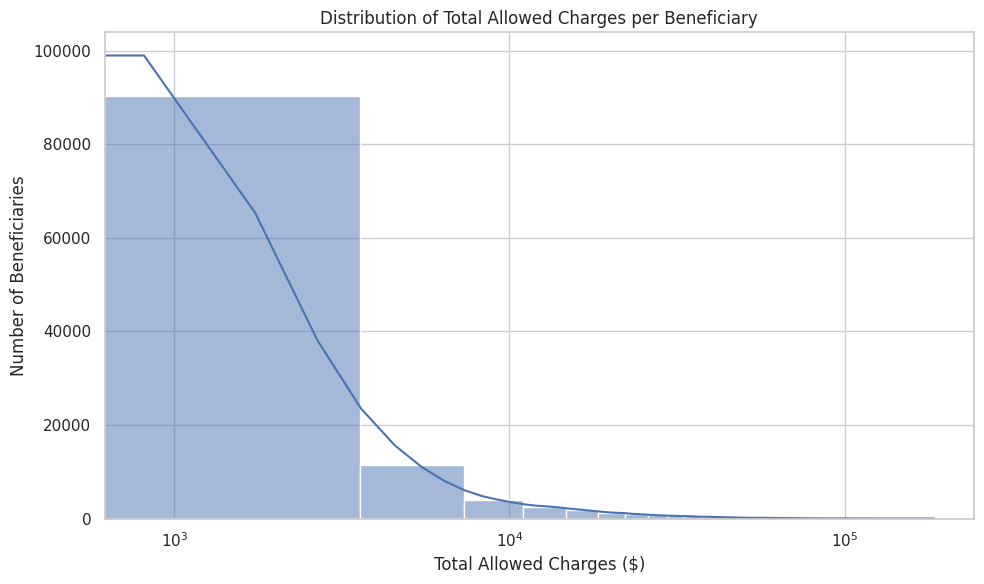

In [57]:
bene['total_allowed_charges'] = bene['MEDREIMB_IP'] + bene['MEDREIMB_OP'] + bene['MEDREIMB_CAR']

print("Descriptive statistics for Total Allowed Charges:")
display(bene['total_allowed_charges'].describe())

# -------------------------------------------------------------------
# Visualize the distribution
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(bene['total_allowed_charges'], bins=50, kde=True)
plt.title('Distribution of Total Allowed Charges per Beneficiary')
plt.xlabel('Total Allowed Charges ($)')
plt.ylabel('Number of Beneficiaries')
plt.xscale('log') # Use log scale due to high skewness
plt.tight_layout()
plt.show()

As expected, total allowed charges per beneficiary is positively skewed even following the log transformation.

# Risk Adjustment & Predictive Modeling: Predicting Total Allowed Charges

In [59]:
import statsmodels.api as sm
import pandas as pd

# -------------------------------------------------------------------
# Recreate beneficiary_all from its base components, ensuring 'total_allowed_charges' is included from bene
# This ensures a clean DataFrame without duplicate 'total_allowed_charges' columns from previous runs
b# -------------------------------------------------------------------
eneficiary_all = (bene
    .merge(beneficiary_flags, on='DESYNPUF_ID', how='left')
    .merge(ed_flags, on='DESYNPUF_ID', how='left'))

# -------------------------------------------------------------------
# Ensure boolean flags and counts are correctly typed and NaNs handled after the new merge
# -------------------------------------------------------------------
beneficiary_all['sleep_flag'] = beneficiary_all['sleep_flag'].astype('boolean').fillna(False)
beneficiary_all['heart_flag'] = beneficiary_all['heart_flag'].astype('boolean').fillna(False)
beneficiary_all['high_ed_user'] = beneficiary_all['high_ed_user'].astype('boolean').fillna(False)
beneficiary_all['ed_visit_count'] = beneficiary_all['ed_visit_count'].astype('Int64').fillna(0)

# -------------------------------------------------------------------
# Define the dependent variable (outcome) for linear regression
# -------------------------------------------------------------------
y = beneficiary_all['total_allowed_charges']

# -------------------------------------------------------------------
# Define the independent variables (predictors)
# Create a copy to avoid SettingWithCopyWarning
# -------------------------------------------------------------------
X = beneficiary_all[['sleep_flag', 'heart_flag', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD']].copy()

# -------------------------------------------------------------------
# Convert boolean flags to integers (0 or 1)
# -------------------------------------------------------------------
X['sleep_flag'] = X['sleep_flag'].astype(int)
X['heart_flag'] = X['heart_flag'].astype(int)

# -------------------------------------------------------------------
# Convert BENE_RACE_CD into dummy variables, dropping the first category to avoid multicollinearity
# -------------------------------------------------------------------
X = pd.get_dummies(X, columns=['BENE_RACE_CD'], drop_first=True, dtype=int)

# -------------------------------------------------------------------
# Add a constant (intercept) to the predictor matrix
# -------------------------------------------------------------------
X = sm.add_constant(X)

# -------------------------------------------------------------------
# Ensure all columns are numeric after dummy encoding
# -------------------------------------------------------------------
X = X.apply(pd.to_numeric, errors='coerce')

# -------------------------------------------------------------------
# Drop rows with any NaN values that might have been introduced by type conversion or missing data
# Align X and y after dropping NaNs
# -------------------------------------------------------------------
valid_indices = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# -------------------------------------------------------------------
# Fit the OLS (Ordinary Least Squares) linear regression model
# -------------------------------------------------------------------
ols_model_charges = sm.OLS(y, X)
result_ols_charges = ols_model_charges.fit()

# -------------------------------------------------------------------
# Print the model summary
# -------------------------------------------------------------------
print(result_ols_charges.summary())

                              OLS Regression Results                             
Dep. Variable:     total_allowed_charges   R-squared:                       0.072
Model:                               OLS   Adj. R-squared:                  0.072
Method:                    Least Squares   F-statistic:                     1502.
Date:                   Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                           20:21:30   Log-Likelihood:            -1.2286e+06
No. Observations:                 116363   AIC:                         2.457e+06
Df Residuals:                     116356   BIC:                         2.457e+06
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

Just like our analyses of ED visits, we also find that sleep disorder diagnosis and heart disease diagnosis are independent predictors of higher total claims charges during this period.

# Summary:

The analysis reveals a clear variation in Emergency Department (ED) visits based on the presence of sleep disorders and cardiovascular disease diagnoses. Individuals with both a sleep disorder and heart disease exhibit the highest mean ED visit count, followed by those with only heart disease, then only a sleep disorder, and finally those with neither condition.

### Data Analysis Key Findings
*   The presence of either a sleep disorder or heart disease, and particularly both, is associated with a higher mean number of ED visits.
*   The proportions of beneficiaries with these conditions are: 4.62% with a sleep flag and 29.71% with a heart flag.

### Insights or Next Steps
*   **Targeted Interventions:** Beneficiaries with heart disease, especially those with co-morbid sleep disorders, may benefit from targeted care management programs or preventive interventions to reduce ED utilization.
*   **Further Investigation into Causality:** I want to explore the reasons behind increased ED visits in these groups. Is it due to uncontrolled symptoms, lack of access to primary care, or acute exacerbations of their conditions? This could involve analyzing the types of ED diagnoses for these beneficiaries in a future project.

###Visualization
* https://public.tableau.com/views/SynPUFHighCostUtilizationAnalysis/Dashboard1


In [70]:
#Download a processed version of the final cleaned data frame
beneficiary_all.to_csv('processed_beneficiary_data.csv', index=False)